# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
#Import relevant libraries

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import xgboost as xgb
import catboost as cb
from scipy.stats import randint as sp_randint

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic


In [3]:
#Load the data
df = pd.read_csv('taxi.csv')

In [5]:
#Inspect the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [7]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [9]:
df.head(12)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [11]:
#Check for duplicates

duplicated = df.duplicated().sum()
print(duplicated)

0


In [13]:
#Check for missing values

df.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [15]:
#Check for unique values
df.nunique()

datetime      26496
num_orders       81
dtype: int64

In [17]:
df['num_orders'].unique()

array([  9,  14,  28,  20,  32,  21,   7,   5,  17,  12,  19,  25,  22,
         8,   6,   4,  10,  13,   2,   3,   0,   1,  11,  15,  16,  23,
        18,  33,  24,  26,  30,  38,  34,  42,  31,  27,  36,  29,  35,
        56,  37,  40,  39,  45,  49,  58,  68,  43,  53,  44,  41,  52,
        46,  57,  47,  64,  61,  50,  48,  55,  62,  54,  71,  78, 119,
        99,  51,  60,  87,  90,  94,  82,  80,  91,  76,  66,  65,  98,
        81,  95,  67], dtype=int64)

In [19]:
#Convert datetime column from string to datetime datatype

df['datetime'] = pd.to_datetime(df['datetime'])

In [21]:
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [23]:
#Set DF index to the datetime column

df = df.set_index('datetime')

In [25]:
display(df.head())
display(df.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

In [31]:
#Check for chronological order

#print(df.index.is_monotonic)

In [33]:
#Resample the data by 1 hour

df = df.resample('1H').sum()
display(df.head(24))
print(df.info())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


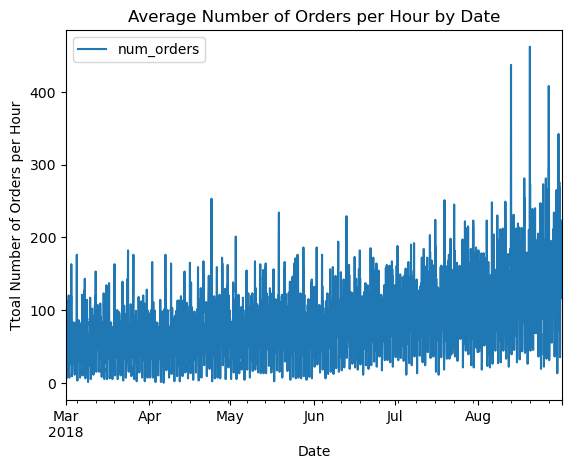

In [35]:
#Plot the data

df.plot()
plt.xlabel('Date')
plt.ylabel('Ttoal Number of Orders per Hour')
plt.title('Average Number of Orders per Hour by Date')
plt.show()

## Analysis

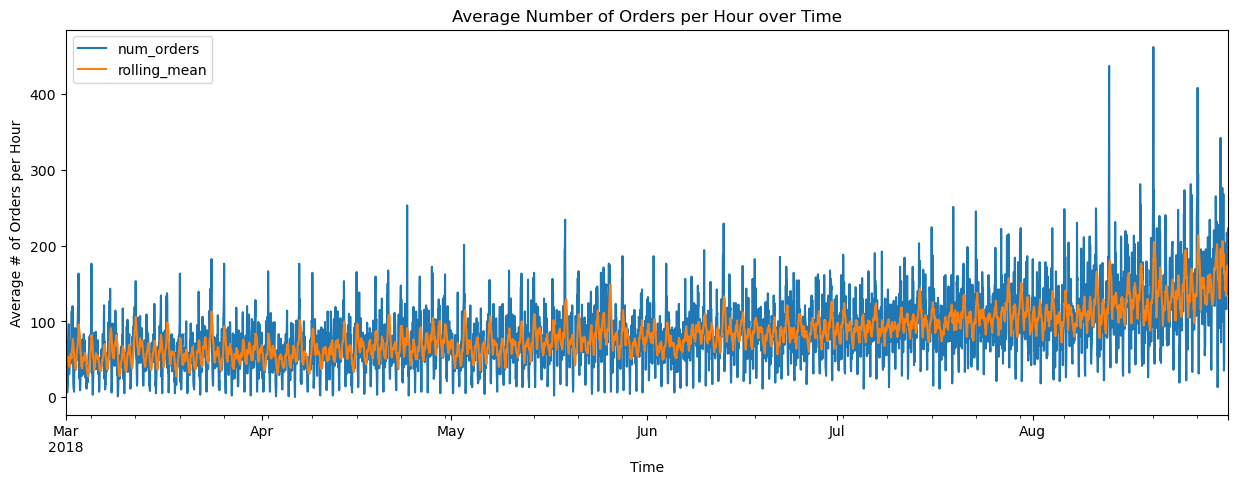

In [38]:
#Add and plot the rolling mean column to the DF

df['rolling_mean'] = df.rolling(10).mean()

df.plot(figsize=(15, 5))
plt.xlabel('Time')
plt.ylabel('Average # of Orders per Hour')
plt.title('Average Number of Orders per Hour over Time')
plt.show()

num_orders      0.000000
rolling_mean    0.203804
dtype: float64


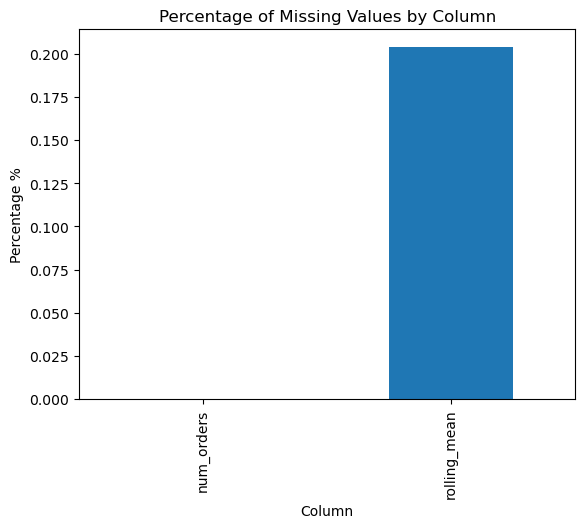

In [40]:
#Check again for missing values
df.isna().sum()

#Compute percentage of missing values
missing_values = df.isna().sum() * 100 / len(df)

print(missing_values)

missing_values.plot.bar()
plt.title('Percentage of Missing Values by Column')
plt.ylabel('Percentage %')
plt.xlabel('Column')
plt.show()

The percentage of missing values from the rolling mean is so low at .20% that I will drop those rows. These values are missing from the intial 9 rows of the data due the window size of the rolling mean being at 10.

In [42]:
df.head(24)

,num_orders,rolling_mean
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,NaN
2018-03-01 04:00:00,43,NaN
2018-03-01 05:00:00,6,NaN
2018-03-01 06:00:00,12,NaN
2018-03-01 07:00:00,15,NaN
2018-03-01 08:00:00,34,NaN


In [44]:
#Drop missing values from rolling mean column

df = df.dropna()
display(df.head(24))
display(df.head(-10))

,num_orders,rolling_mean
datetime,,
2018-03-01 09:00:00,69,52.5
2018-03-01 10:00:00,64,46.5
2018-03-01 11:00:00,96,47.6
2018-03-01 12:00:00,30,43.5
2018-03-01 13:00:00,32,40.1
2018-03-01 14:00:00,48,40.6
2018-03-01 15:00:00,66,46.6
2018-03-01 16:00:00,43,49.7
2018-03-01 17:00:00,44,52.6


,num_orders,rolling_mean
datetime,,
2018-03-01 09:00:00,69,52.5
2018-03-01 10:00:00,64,46.5
2018-03-01 11:00:00,96,47.6
2018-03-01 12:00:00,30,43.5
2018-03-01 13:00:00,32,40.1
...,...,...
2018-08-31 09:00:00,203,161.1
2018-08-31 10:00:00,191,152.6
2018-08-31 11:00:00,167,149.9


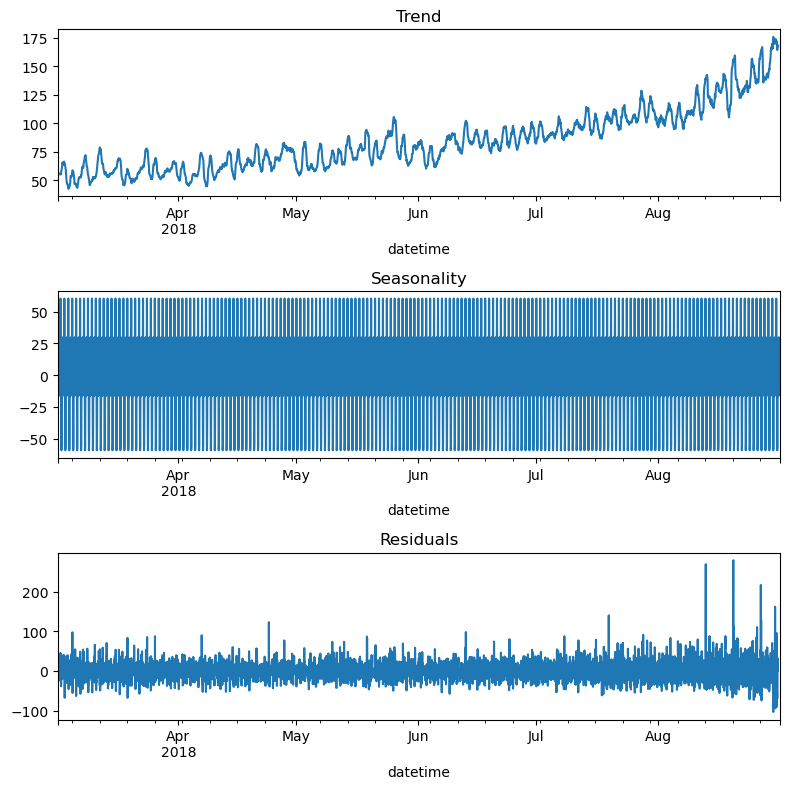

In [46]:
#Check for trends and seasonality

decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Here we see that the trend is for a substantially increased number of taxi orders per hour during the months of July and August, with demand peaking at the end of August.

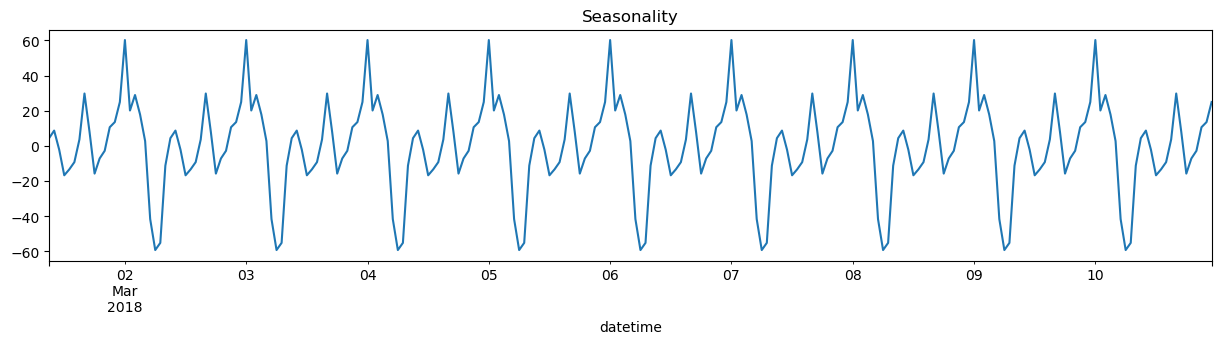

In [50]:
#Replot seasonal component for the first week of March, 2018

decomposed.seasonal['2018-03-01': '2018-03-10'].plot(figsize=(15,3))
plt.title('Seasonality')
plt.show()

The seasonality is 1 day.

In [52]:
#Find the rolling standard deviation

df['rolling_std'] = df['num_orders'].rolling(10).std()

#Fill first 9 NaN values of the new rolling std column with 0

df = df.dropna()
df.head(20)

,num_orders,rolling_mean,rolling_std
datetime,,,
2018-03-01 18:00:00,73,56.5,20.678760
2018-03-01 19:00:00,45,54.1,20.458359
2018-03-01 20:00:00,61,53.8,20.318574
2018-03-01 21:00:00,66,50.8,14.883249
2018-03-01 22:00:00,113,59.1,22.951398
2018-03-01 23:00:00,58,61.7,20.923405
2018-03-02 00:00:00,90,65.9,22.052715
2018-03-02 01:00:00,120,71.3,27.912761
2018-03-02 02:00:00,75,74.5,26.082135


<div class="alert alert-info">
  Dropped missing values above instead of filling with 0.
</div>

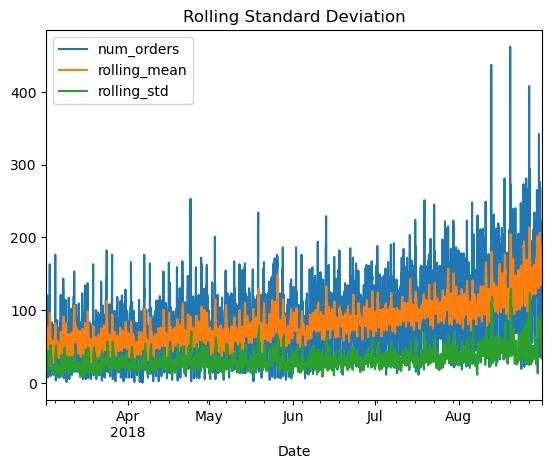

In [54]:
df.plot()
plt.xlabel('Date')
plt.title('Rolling Standard Deviation')
plt.show()

Here we can note that the time series is not stationary; the mean changes over time, although the standard deviation remains close to constant. 

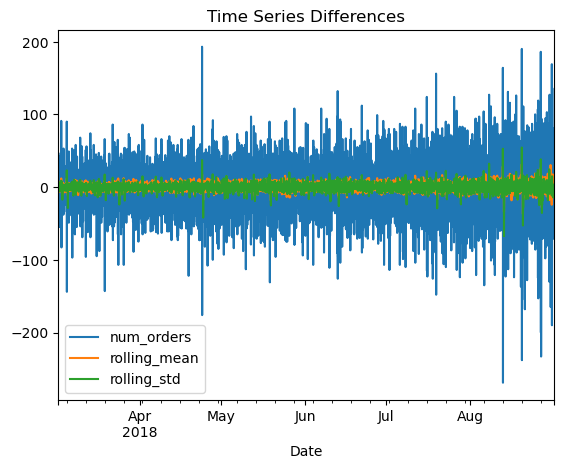

In [57]:
#Calculate the time series differences

df_differences = df - df.shift()

#Fill NaN Values with 0 for first row

df_differences = df_differences.dropna()

#Plot the time series differences

df_differences.plot()
plt.title('Time Series Differences')
plt.xlabel('Date')

plt.show()

With the time series' mean and std remaining stagnant, this data is now more stationary and can be forecasted.

In [59]:
#Create features for models

def make_features(data, max_lag):
    data['day_of_week'] = data.index.dayofweek #DayOfWeek
    data['month'] = data.index.month #Month
    data['hour'] = data.index.hour #Hour
    data['day'] = data.index.day #Day
    #df_differences = df_differences.drop(['dayofweek'], axis=1)

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

make_features(df_differences, 20)

df_differences



,num_orders,rolling_mean,rolling_std,day_of_week,month,hour,day,lag_1,lag_2,lag_3,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 19:00:00,-28.0,-2.4,-0.220401,3,3,19,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 20:00:00,16.0,-0.3,-0.139785,3,3,20,1,-28.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 21:00:00,5.0,-3.0,-5.435325,3,3,21,1,16.0,-28.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 22:00:00,47.0,8.3,8.068149,3,3,22,1,5.0,16.0,-28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 23:00:00,-55.0,2.6,-2.027993,3,3,23,1,47.0,5.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,-71.0,-6.7,0.094861,4,8,19,31,-10.0,20.0,81.0,...,136.0,11.0,-43.0,-190.0,169.0,-131.0,36.0,-82.0,30.0,88.0
2018-08-31 20:00:00,18.0,-3.7,-0.912772,4,8,20,31,-71.0,-10.0,20.0,...,21.0,136.0,11.0,-43.0,-190.0,169.0,-131.0,36.0,-82.0,30.0
2018-08-31 21:00:00,5.0,-0.8,-0.012904,4,8,21,31,18.0,-71.0,-10.0,...,-12.0,21.0,136.0,11.0,-43.0,-190.0,169.0,-131.0,36.0,-82.0


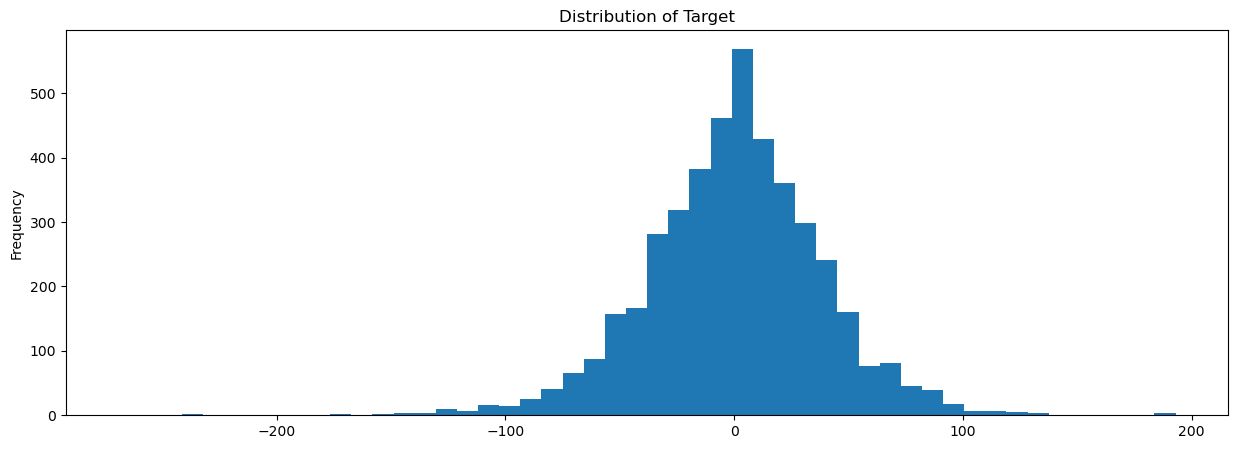

In [66]:
#Check distribution of target

df_differences['num_orders'].plot(kind='hist', bins=50, figsize=(15, 5))
plt.title('Distribution of Target')
plt.show()

The stationary dataframe has a normal distrubtion.

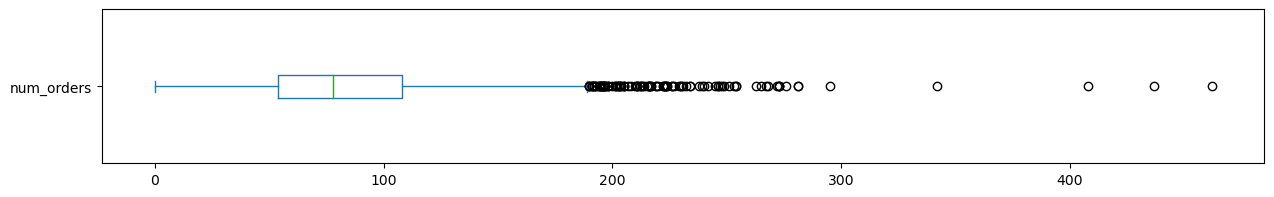

In [68]:
#Plot a boxplot of target

df['num_orders'].plot(kind='box', vert=False, figsize=(15,2))
plt.show()

The original dataframe has a median number of orders of 13 and a substantial number of outliers above the max of 31.

## Training

In [72]:
df_differences.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4397 entries, 2018-03-01 19:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4397 non-null   float64
 1   rolling_mean  4397 non-null   float64
 2   rolling_std   4397 non-null   float64
 3   day_of_week   4397 non-null   int32  
 4   month         4397 non-null   int32  
 5   hour          4397 non-null   int32  
 6   day           4397 non-null   int32  
 7   lag_1         4396 non-null   float64
 8   lag_2         4395 non-null   float64
 9   lag_3         4394 non-null   float64
 10  lag_4         4393 non-null   float64
 11  lag_5         4392 non-null   float64
 12  lag_6         4391 non-null   float64
 13  lag_7         4390 non-null   float64
 14  lag_8         4389 non-null   float64
 15  lag_9         4388 non-null   float64
 16  lag_10        4387 non-null   float64
 17  lag_11        4386 non-null

In [74]:
df_differences = df_differences.dropna()
df_differences = df_differences.drop(['rolling_mean', 'rolling_std'], axis=1)
display(df_differences.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4377 entries, 2018-03-02 15:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   num_orders   4377 non-null   float64
 1   day_of_week  4377 non-null   int32  
 2   month        4377 non-null   int32  
 3   hour         4377 non-null   int32  
 4   day          4377 non-null   int32  
 5   lag_1        4377 non-null   float64
 6   lag_2        4377 non-null   float64
 7   lag_3        4377 non-null   float64
 8   lag_4        4377 non-null   float64
 9   lag_5        4377 non-null   float64
 10  lag_6        4377 non-null   float64
 11  lag_7        4377 non-null   float64
 12  lag_8        4377 non-null   float64
 13  lag_9        4377 non-null   float64
 14  lag_10       4377 non-null   float64
 15  lag_11       4377 non-null   float64
 16  lag_12       4377 non-null   float64
 17  lag_13       4377 non-null   float64
 18  lag_

None

In [76]:
#Split the time series differences dataset in to training and testing sets with a test size of 10%

train, test = train_test_split(df_differences, shuffle=False, test_size=0.091)

In [78]:
print(train.shape)
print(test.shape)

print(test.shape[0] / train.shape[0] * 100) #Test size of 10%

(3978, 25)
(399, 25)
10.030165912518854


In [80]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 15:00:00 2018-08-15 08:00:00
2018-08-15 09:00:00 2018-08-31 23:00:00


### Sanity Check

In [82]:
print('Median daily number of orders:', test['num_orders'].median())

pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print('RMSE:', mean_squared_error(test, pred_previous) ** 0.5)

Median daily number of orders: 2.0
RMSE: 85.87867410869049


### Linear Regression

In [84]:
#Define features and target

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [86]:
%%time
#Initialize the LR model

tscv = TimeSeriesSplit(n_splits=5)

model_lr = LinearRegression()
params_grid = [{'positive': [True, False],
               'fit_intercept': [True, False],
               'n_jobs': list(range(1, 200))}]

lr = RandomizedSearchCV(model_lr, params_grid, scoring='neg_root_mean_squared_error', cv=tscv, random_state=12345)
lr.fit(features_train, target_train)

pred_train = lr.predict(features_test)

print('Best Params:\n', lr.best_params_)
print("RMSE:", mean_squared_error(target_test, pred_train) ** 0.5)

Best Params:
 {'positive': False, 'n_jobs': 129, 'fit_intercept': True}
RMSE: 50.680185491458005
CPU times: total: 1.05 s
Wall time: 456 ms


C:\Users\User\AppData\Local\Temp\ipykernel_22496\3986766981.py:12: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


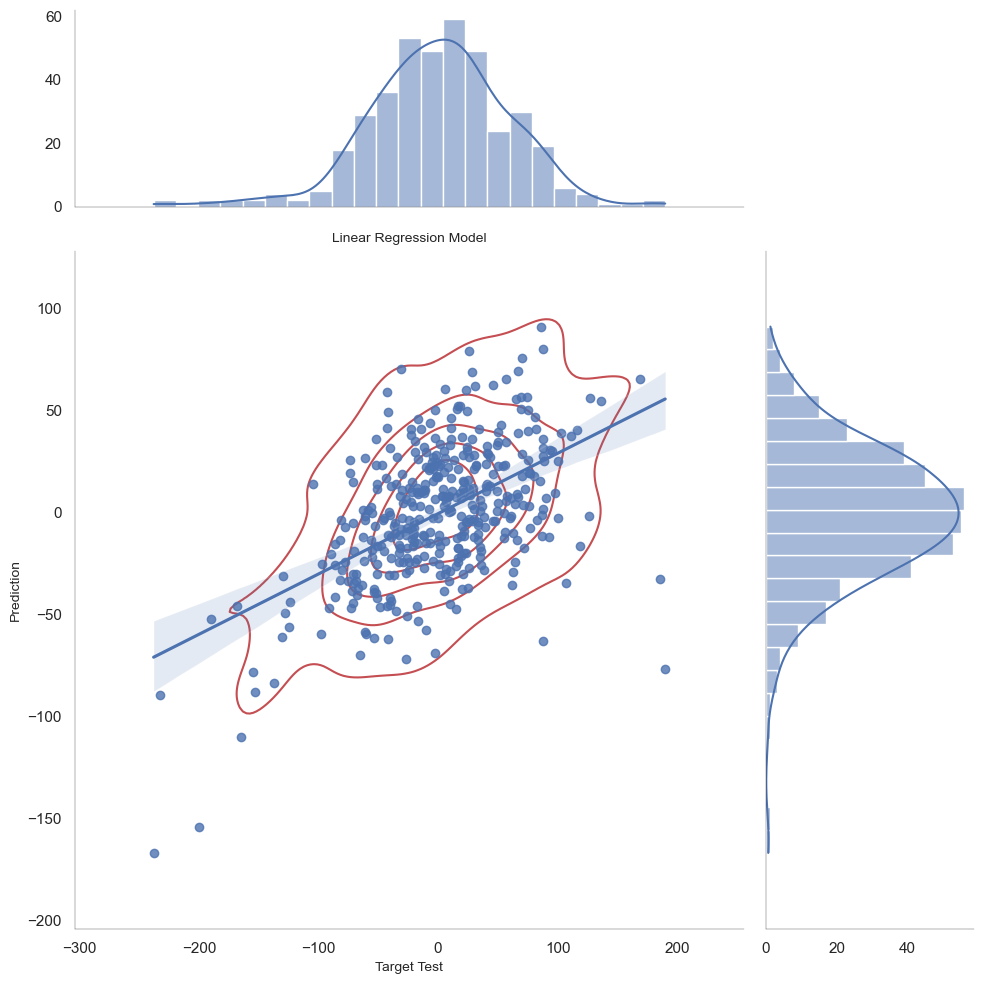

In [88]:
#Plot linear regression model

sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.25

g = sns.jointplot(x = target_test, y = pred_train, kind='reg', palette='mako', height=10, ratio=3, marginal_ticks=True, color="b")
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)

plt.title('Linear Regression Model', fontsize=10)
g.set_axis_labels('Target Test', 'Prediction', fontsize=10)

g.fig.tight_layout()
plt.show()

### Autoregressive Model

### Random Forest Regression

In [90]:
%%time

# Initializing the model
model_rf = RandomForestRegressor(random_state=54321)

params_grid_rf = [{'max_depth': [1, 20],
                    'max_features': sp_randint(1, 10),
                  'min_samples_split': [1, 12],
                  'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
                  'warm_start': [True, False],
                  'n_estimators': [350]}]

rf = RandomizedSearchCV(model_rf, params_grid_rf, scoring='neg_root_mean_squared_error', cv=tscv)
rf.fit(features_train, target_train)

pred_rf = rf.predict(features_test)

print('Best Random Forest Parameters:', rf.best_params_)
print('')
print('RMSE:', mean_squared_error(target_test, pred_rf) ** 0.5)

C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
35 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\User\anaconda3\Lib\site-packages\sklea

Best Random Forest Parameters: {'criterion': 'absolute_error', 'max_depth': 20, 'max_features': 2, 'min_samples_split': 12, 'n_estimators': 350, 'warm_start': True}

RMSE: 52.36149809900607
CPU times: total: 2min 1s
Wall time: 2min 16s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

C:\Users\User\AppData\Local\Temp\ipykernel_22496\3703837691.py:10: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


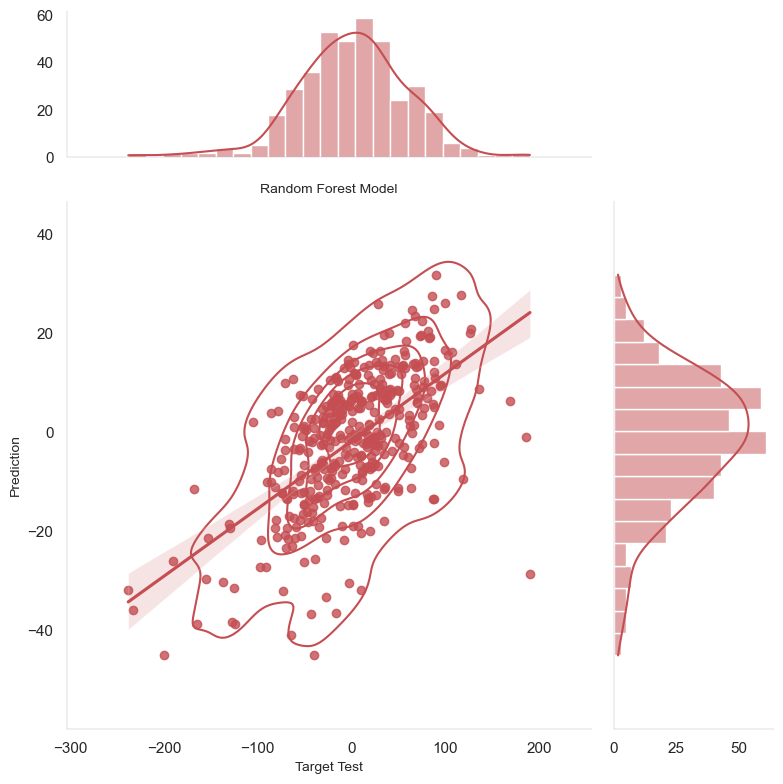

In [92]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1

g = sns.jointplot(x = target_test, y = pred_rf, kind='reg', palette='mako', height=8, ratio=3, marginal_ticks=True, color="r")
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)

plt.title('Random Forest Model', fontsize=10)
g.set_axis_labels('Target Test', 'Prediction', fontsize=10)

g.fig.tight_layout()
plt.show()

### SGD Regression

In [94]:
%%time
model_sgd = SGDRegressor(random_state=54321)
params_grid_sgd = [{  "alpha": [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0010],
                     "fit_intercept": [True, False], 
                     "learning_rate": ['constant', 'optimal', 'invscaling', 'adaptive'],
                     "penalty": ['l2', 'l1', 'elasticnet', None],
                      "average": [True, False],
                      "shuffle": [True, False],
                      "early_stopping": [True, False],
                       "max_iter": [1000, 6000]}]

sgd = RandomizedSearchCV(model_sgd, params_grid_sgd, scoring='neg_root_mean_squared_error', cv=tscv)
sgd.fit(features_train, target_train)

pred_sgd = sgd.predict(features_test)

print('Best Params:\n', sgd.best_params_)
print()
print('RMSE:', mean_squared_error(target_test, pred_sgd) ** 0.5)
print('Runtime:')

C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Best Params:
 {'shuffle': False, 'penalty': 'l1', 'max_iter': 6000, 'learning_rate': 'adaptive', 'fit_intercept': True, 'early_stopping': True, 'average': True, 'alpha': 0.0005}

RMSE: 29253785246.88996
Runtime:
CPU times: total: 36 s
Wall time: 37.8 s


C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


C:\Users\User\AppData\Local\Temp\ipykernel_22496\2790305707.py:10: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


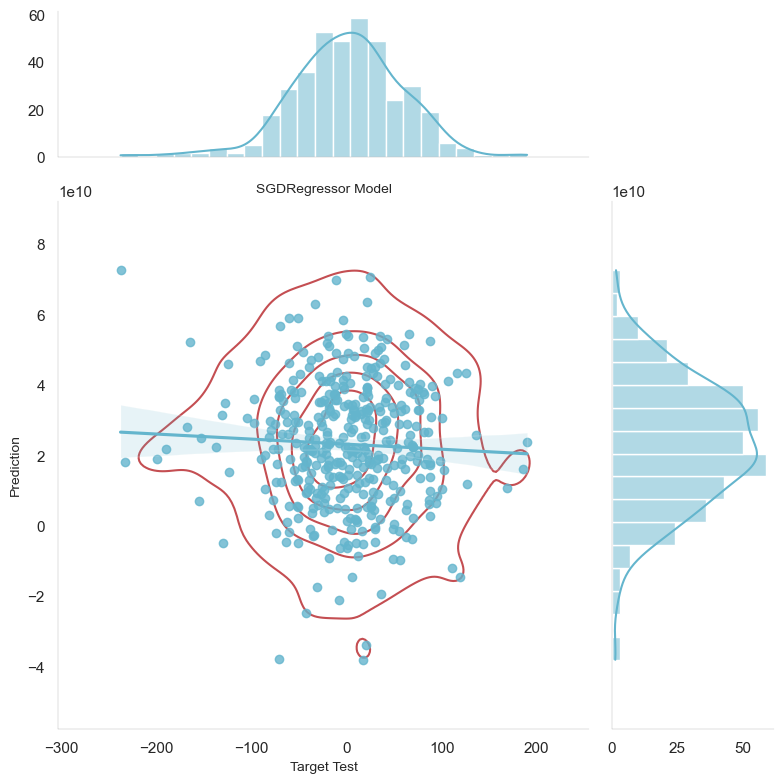

In [97]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1

g = sns.jointplot(x = target_test, y = pred_sgd, kind='reg', palette='mako', height=8, ratio=3, marginal_ticks=True, color="c")
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)

plt.title('SGDRegressor Model', fontsize=10)
g.set_axis_labels('Target Test', 'Prediction', fontsize=10)

g.fig.tight_layout()
plt.show()

### LGBM Regression

In [101]:
%%time

#Initialize the LGBM Model

model_lgbm = lgb.LGBMRegressor(random_state=54321)


#Definte initial set of LGBM Parameters

params_grid_lgbm = {
    'max_depth': [1, 20],
    'metric': ['rmse'],
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [31, 150],
    'learning_rate': [0.01, 0.05, 0.08, 0.09, 0.1, 0.11, 0.15, 0.2],
    'n_estimators': [20, 300],
    'n_jobs': [1, 30],
    'class_weight': ['balanced', None],
}

lgbm = RandomizedSearchCV(model_lgbm, params_grid_lgbm, scoring='neg_root_mean_squared_error', cv=tscv)
lgbm.fit(features_train, target_train)

pred_lgbm = lgbm.predict(features_test)

print('Best Params:\n', lgbm.best_params_)
print()
print('RMSE:', mean_squared_error(target_test, pred_lgbm) ** 0.5)
print('Runtime:')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2047
[LightGBM] [Info] Number of data points in the train set: 663, number of used features: 23
[LightGBM] [Info] Start training from score -0.043741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2629
[LightGBM] [Info] Number of data points in the train set: 1326, number of used features: 24
[LightGBM] [Info] Start training from score 0.014329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2987
[LightGBM] [Info] Number of data points in the train set: 

C:\Users\User\AppData\Local\Temp\ipykernel_22496\4062743486.py:10: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


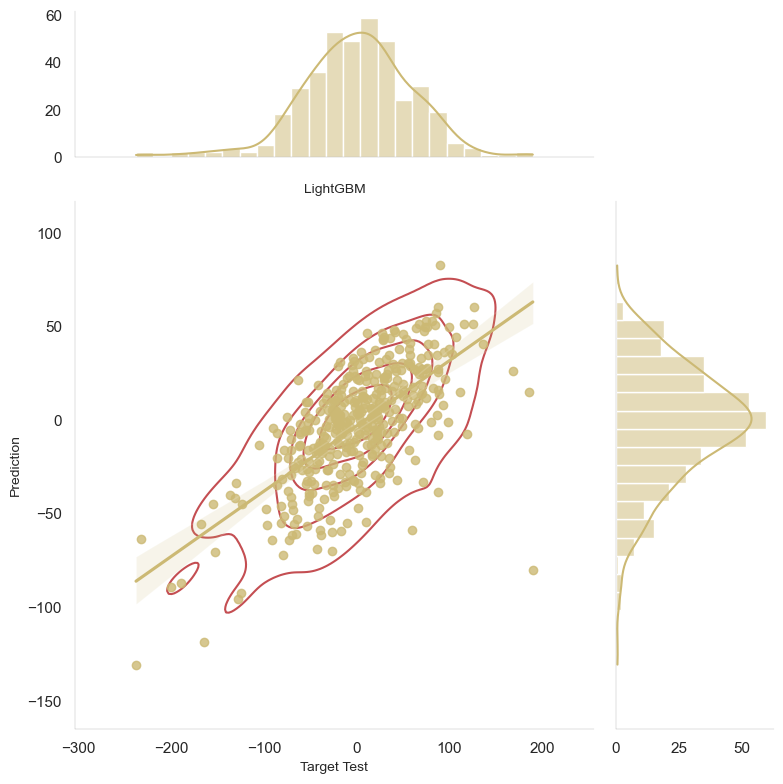

In [103]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1

g = sns.jointplot(x = target_test, y = pred_lgbm, kind='reg', palette='mako', height=8, ratio=3, marginal_ticks=True, color="y")
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)

plt.title('LightGBM', fontsize=10)
g.set_axis_labels('Target Test', 'Prediction', fontsize=10)

g.fig.tight_layout()
plt.show()

### XGBoost

In [105]:
%%time 

model_xgb = XGBRegressor(random_state=12345)

params_grid_xgb = {"booster": ["gblinear", 'dart', 'gbtree'],
             "validate_parameters": [True, False],
             "max_depth": [1, 10],
             "subsample": [0.5, 1],
             "sampling_method": ["uniform", "gradient_based", "subsample"],
             "tree_method": ["auto", "exact", "approx"],
             "max_leaves": [2, 10],
             "feature_selector": ["shuffle", "cyclic", "random"],
             "updater": ["coord_descent", "shotgun"],
             "eta": [0.1, 0.2, 0.3]
        }



xgb = RandomizedSearchCV(model_xgb, params_grid_xgb, scoring='neg_root_mean_squared_error', cv=tscv)
xgb.fit(features_train, target_train)

pred_xgb = xgb.predict(features_test)

print('Best Params:\n', xgb.best_params_)
print()
print('RMSE:', mean_squared_error(target_test, pred_xgb) ** 0.5)
print('Runtime:')

C:\Users\User\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:59:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:33: You have manually specified the `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
  warnings.warn(smsg, UserWarning)
C:\Users\User\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:59:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_depth", "max_leaves", "sampling_method", "subsample", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\User\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:59:58] WARNING: C:\buildkite-agent\builds\bu

Best Params:
 {'validate_parameters': True, 'updater': 'coord_descent', 'tree_method': 'auto', 'subsample': 1, 'sampling_method': 'uniform', 'max_leaves': 10, 'max_depth': 1, 'feature_selector': 'cyclic', 'eta': 0.3, 'booster': 'gblinear'}

RMSE: 50.74044343045895
Runtime:
CPU times: total: 23.2 s
Wall time: 3.56 s


C:\Users\User\AppData\Local\Temp\ipykernel_22496\3730830084.py:10: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


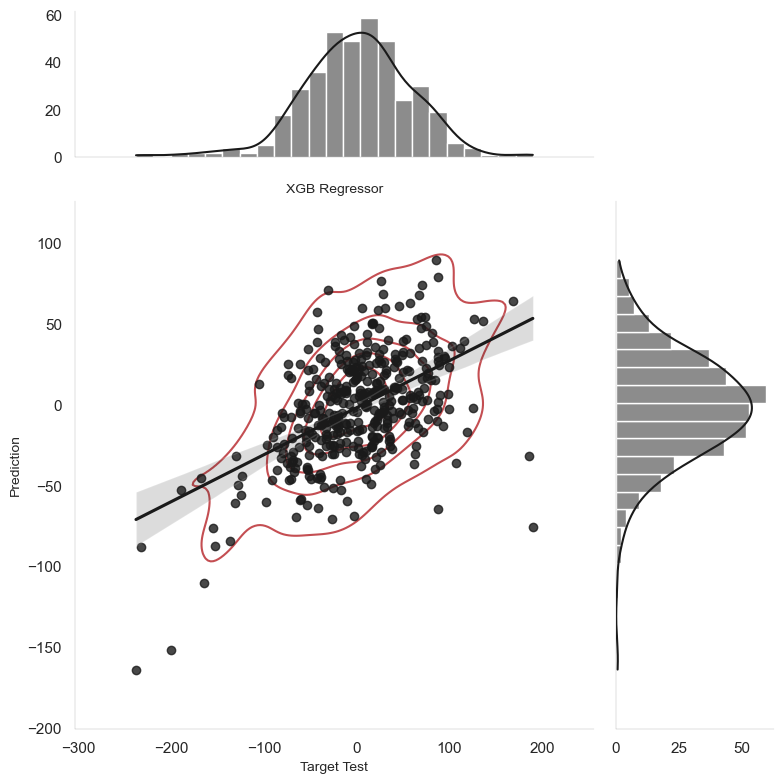

In [107]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1

g = sns.jointplot(x = target_test, y = pred_xgb, kind='reg', palette='mako', height=8, ratio=3, marginal_ticks=True, color="k")
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)

plt.title('XGB Regressor', fontsize=10)
g.set_axis_labels('Target Test', 'Prediction', fontsize=10)

g.fig.tight_layout()
plt.show()

### CatBoost

In [109]:
%%time

#Initialize CatBoost Model
model_cb = cb.CatBoostRegressor(loss_function='RMSE', random_state=54321)

#Hyperparameters
params_grid_cb = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

cb = RandomizedSearchCV(model_cb, params_grid_cb, scoring='neg_root_mean_squared_error', cv=tscv)
cb.fit(features_train, target_train)

pred_cb = cb.predict(features_test)

print('Best Params:\n', cb.best_params_)
print()
print('RMSE:', mean_squared_error(target_test, pred_cb) ** 0.5)
print('Runtime:')

0:	learn: 28.5121990	total: 160ms	remaining: 31.9s
1:	learn: 27.6963877	total: 162ms	remaining: 16.1s
2:	learn: 27.2512957	total: 165ms	remaining: 10.8s
3:	learn: 26.4940974	total: 167ms	remaining: 8.19s
4:	learn: 26.1277478	total: 169ms	remaining: 6.61s
5:	learn: 25.3335897	total: 171ms	remaining: 5.54s
6:	learn: 24.6849240	total: 174ms	remaining: 4.79s
7:	learn: 24.2837035	total: 176ms	remaining: 4.22s
8:	learn: 23.7238724	total: 178ms	remaining: 3.77s
9:	learn: 23.4483282	total: 180ms	remaining: 3.42s
10:	learn: 22.9535928	total: 182ms	remaining: 3.12s
11:	learn: 22.5114099	total: 184ms	remaining: 2.88s
12:	learn: 22.0931404	total: 185ms	remaining: 2.67s
13:	learn: 21.7444284	total: 187ms	remaining: 2.49s
14:	learn: 21.3741415	total: 190ms	remaining: 2.34s
15:	learn: 21.0529579	total: 192ms	remaining: 2.2s
16:	learn: 20.7066291	total: 194ms	remaining: 2.08s
17:	learn: 20.3454120	total: 196ms	remaining: 1.98s
18:	learn: 19.9726690	total: 198ms	remaining: 1.88s
19:	learn: 19.7593563	t

141:	learn: 17.6643863	total: 395ms	remaining: 22.2ms
142:	learn: 17.6122822	total: 398ms	remaining: 19.5ms
143:	learn: 17.5911403	total: 400ms	remaining: 16.7ms
144:	learn: 17.5463101	total: 403ms	remaining: 13.9ms
145:	learn: 17.4977414	total: 405ms	remaining: 11.1ms
146:	learn: 17.4429148	total: 408ms	remaining: 8.32ms
147:	learn: 17.4127688	total: 410ms	remaining: 5.54ms
148:	learn: 17.3696240	total: 413ms	remaining: 2.77ms
149:	learn: 17.3310578	total: 416ms	remaining: 0us
0:	learn: 31.9315521	total: 3.32ms	remaining: 495ms
1:	learn: 31.2535331	total: 6.5ms	remaining: 481ms
2:	learn: 30.5530177	total: 9.69ms	remaining: 475ms
3:	learn: 30.2437475	total: 12.5ms	remaining: 458ms
4:	learn: 29.9612764	total: 15.5ms	remaining: 450ms
5:	learn: 29.5956837	total: 18.5ms	remaining: 443ms
6:	learn: 29.2978846	total: 21.4ms	remaining: 438ms
7:	learn: 28.9396631	total: 24.3ms	remaining: 431ms
8:	learn: 28.6343639	total: 27.3ms	remaining: 427ms
9:	learn: 28.4565720	total: 30.2ms	remaining: 423m

0:	learn: 33.1311422	total: 3.49ms	remaining: 520ms
1:	learn: 32.5131225	total: 6.99ms	remaining: 517ms
2:	learn: 31.8327070	total: 10.3ms	remaining: 507ms
3:	learn: 31.2029966	total: 13.7ms	remaining: 500ms
4:	learn: 30.8851849	total: 16.9ms	remaining: 491ms
5:	learn: 30.4255481	total: 20.2ms	remaining: 486ms
6:	learn: 30.2154176	total: 23.4ms	remaining: 478ms
7:	learn: 29.8846362	total: 26.6ms	remaining: 472ms
8:	learn: 29.5546377	total: 29.9ms	remaining: 468ms
9:	learn: 29.2298473	total: 33.2ms	remaining: 465ms
10:	learn: 29.0164834	total: 36.4ms	remaining: 460ms
11:	learn: 28.7687220	total: 39.7ms	remaining: 456ms
12:	learn: 28.5912977	total: 42.8ms	remaining: 451ms
13:	learn: 28.3959091	total: 46ms	remaining: 447ms
14:	learn: 28.1765006	total: 49.2ms	remaining: 443ms
15:	learn: 28.0200055	total: 52.4ms	remaining: 439ms
16:	learn: 27.8916899	total: 55.6ms	remaining: 435ms
17:	learn: 27.7440446	total: 59ms	remaining: 433ms
18:	learn: 27.6420214	total: 62.2ms	remaining: 429ms
19:	lea

96:	learn: 15.5270433	total: 195ms	remaining: 106ms
97:	learn: 15.4517457	total: 197ms	remaining: 104ms
98:	learn: 15.3527338	total: 199ms	remaining: 102ms
99:	learn: 15.2826953	total: 201ms	remaining: 100ms
100:	learn: 15.2345801	total: 202ms	remaining: 98.2ms
101:	learn: 15.1753321	total: 204ms	remaining: 96.1ms
102:	learn: 15.1138622	total: 206ms	remaining: 94.1ms
103:	learn: 15.0151984	total: 208ms	remaining: 92.1ms
104:	learn: 14.9864268	total: 210ms	remaining: 90ms
105:	learn: 14.8645887	total: 212ms	remaining: 88ms
106:	learn: 14.8123926	total: 214ms	remaining: 85.9ms
107:	learn: 14.7206905	total: 216ms	remaining: 84ms
108:	learn: 14.6312041	total: 218ms	remaining: 81.9ms
109:	learn: 14.6036746	total: 220ms	remaining: 79.9ms
110:	learn: 14.5877173	total: 222ms	remaining: 77.8ms
111:	learn: 14.5008142	total: 223ms	remaining: 75.8ms
112:	learn: 14.4802769	total: 225ms	remaining: 73.8ms
113:	learn: 14.4205482	total: 235ms	remaining: 74.2ms
114:	learn: 14.3568642	total: 237ms	remain

0:	learn: 31.1839273	total: 2.74ms	remaining: 409ms
1:	learn: 30.4897718	total: 5.65ms	remaining: 418ms
2:	learn: 29.8084306	total: 8.33ms	remaining: 408ms
3:	learn: 29.4486054	total: 10.9ms	remaining: 397ms
4:	learn: 29.1785471	total: 13.5ms	remaining: 390ms
5:	learn: 28.8628599	total: 16.1ms	remaining: 386ms
6:	learn: 28.6019331	total: 18.7ms	remaining: 383ms
7:	learn: 28.2314954	total: 21.3ms	remaining: 379ms
8:	learn: 27.9053529	total: 24.1ms	remaining: 378ms
9:	learn: 27.6962715	total: 26.8ms	remaining: 375ms
10:	learn: 27.4499312	total: 29.4ms	remaining: 372ms
11:	learn: 27.2013756	total: 32.2ms	remaining: 370ms
12:	learn: 27.0804577	total: 34.8ms	remaining: 367ms
13:	learn: 26.9108961	total: 37.4ms	remaining: 364ms
14:	learn: 26.7312560	total: 40.1ms	remaining: 361ms
15:	learn: 26.5929293	total: 42.9ms	remaining: 359ms
16:	learn: 26.4296987	total: 45.4ms	remaining: 355ms
17:	learn: 26.1864042	total: 48.1ms	remaining: 353ms
18:	learn: 26.0343706	total: 50.8ms	remaining: 350ms
19:

29:	learn: 25.6020392	total: 92.2ms	remaining: 369ms
30:	learn: 25.4701059	total: 95.6ms	remaining: 367ms
31:	learn: 25.3620216	total: 98.7ms	remaining: 364ms
32:	learn: 25.2823024	total: 101ms	remaining: 360ms
33:	learn: 25.2091884	total: 104ms	remaining: 356ms
34:	learn: 25.1374466	total: 107ms	remaining: 352ms
35:	learn: 25.0609296	total: 110ms	remaining: 349ms
36:	learn: 25.0211497	total: 113ms	remaining: 345ms
37:	learn: 24.9402813	total: 116ms	remaining: 342ms
38:	learn: 24.7555452	total: 119ms	remaining: 339ms
39:	learn: 24.6853220	total: 122ms	remaining: 336ms
40:	learn: 24.5702546	total: 125ms	remaining: 332ms
41:	learn: 24.5365263	total: 128ms	remaining: 328ms
42:	learn: 24.4703523	total: 131ms	remaining: 325ms
43:	learn: 24.3828566	total: 133ms	remaining: 322ms
44:	learn: 24.3375204	total: 136ms	remaining: 318ms
45:	learn: 24.2892009	total: 139ms	remaining: 315ms
46:	learn: 24.2328703	total: 142ms	remaining: 311ms
47:	learn: 24.1334950	total: 145ms	remaining: 308ms
48:	learn

61:	learn: 24.4255720	total: 199ms	remaining: 283ms
62:	learn: 24.3814073	total: 203ms	remaining: 280ms
63:	learn: 24.3490576	total: 206ms	remaining: 277ms
64:	learn: 24.3030715	total: 210ms	remaining: 274ms
65:	learn: 24.2598930	total: 213ms	remaining: 271ms
66:	learn: 24.2231142	total: 216ms	remaining: 268ms
67:	learn: 24.1534864	total: 219ms	remaining: 264ms
68:	learn: 24.0868097	total: 222ms	remaining: 261ms
69:	learn: 24.0477350	total: 234ms	remaining: 267ms
70:	learn: 24.0357914	total: 238ms	remaining: 265ms
71:	learn: 23.9432111	total: 242ms	remaining: 262ms
72:	learn: 23.9083570	total: 245ms	remaining: 259ms
73:	learn: 23.8486674	total: 249ms	remaining: 255ms
74:	learn: 23.7480831	total: 252ms	remaining: 252ms
75:	learn: 23.6976806	total: 255ms	remaining: 249ms
76:	learn: 23.6858570	total: 258ms	remaining: 245ms
77:	learn: 23.6632984	total: 261ms	remaining: 241ms
78:	learn: 23.6318074	total: 265ms	remaining: 238ms
79:	learn: 23.6100444	total: 268ms	remaining: 234ms
80:	learn: 2

7:	learn: 28.5341544	total: 8.93ms	remaining: 103ms
8:	learn: 28.2884524	total: 10.1ms	remaining: 102ms
9:	learn: 28.0974215	total: 11.1ms	remaining: 100ms
10:	learn: 27.9801124	total: 12.2ms	remaining: 98.9ms
11:	learn: 27.8210339	total: 13.3ms	remaining: 97.2ms
12:	learn: 27.6871315	total: 14.3ms	remaining: 95.6ms
13:	learn: 27.5201058	total: 15.4ms	remaining: 94.6ms
14:	learn: 27.3376765	total: 16.4ms	remaining: 93.2ms
15:	learn: 27.2267466	total: 17.5ms	remaining: 91.8ms
16:	learn: 27.0871035	total: 18.5ms	remaining: 90.5ms
17:	learn: 26.9907543	total: 19.6ms	remaining: 89.4ms
18:	learn: 26.9117942	total: 20.7ms	remaining: 88.1ms
19:	learn: 26.8231893	total: 21.7ms	remaining: 86.8ms
20:	learn: 26.7296573	total: 22.8ms	remaining: 85.7ms
21:	learn: 26.5836366	total: 23.8ms	remaining: 84.5ms
22:	learn: 26.4964150	total: 24.8ms	remaining: 83.2ms
23:	learn: 26.4369536	total: 25.9ms	remaining: 82ms
24:	learn: 26.3528091	total: 27ms	remaining: 81ms
25:	learn: 26.2806571	total: 28ms	remain

0:	learn: 32.2261926	total: 1.51ms	remaining: 150ms
1:	learn: 31.8892320	total: 3.11ms	remaining: 153ms
2:	learn: 31.5684566	total: 4.5ms	remaining: 146ms
3:	learn: 31.2434744	total: 5.92ms	remaining: 142ms
4:	learn: 30.9029403	total: 7.25ms	remaining: 138ms
5:	learn: 30.6853600	total: 8.59ms	remaining: 135ms
6:	learn: 30.4022565	total: 9.89ms	remaining: 131ms
7:	learn: 30.1861369	total: 11.3ms	remaining: 130ms
8:	learn: 29.9863554	total: 12.7ms	remaining: 128ms
9:	learn: 29.7914903	total: 14ms	remaining: 126ms
10:	learn: 29.6316240	total: 15.3ms	remaining: 124ms
11:	learn: 29.4470049	total: 16.7ms	remaining: 123ms
12:	learn: 29.3371383	total: 18.1ms	remaining: 121ms
13:	learn: 29.2449089	total: 19.4ms	remaining: 119ms
14:	learn: 29.1159844	total: 20.7ms	remaining: 117ms
15:	learn: 29.0262981	total: 22.1ms	remaining: 116ms
16:	learn: 28.9244557	total: 23.4ms	remaining: 114ms
17:	learn: 28.8581547	total: 24.8ms	remaining: 113ms
18:	learn: 28.7853899	total: 26ms	remaining: 111ms
19:	lear

0:	learn: 29.1728832	total: 5.32ms	remaining: 527ms
1:	learn: 28.8918198	total: 9.98ms	remaining: 489ms
2:	learn: 28.7318231	total: 14.5ms	remaining: 468ms
3:	learn: 28.4829822	total: 19ms	remaining: 457ms
4:	learn: 28.2981371	total: 23.6ms	remaining: 449ms
5:	learn: 28.0692579	total: 28.2ms	remaining: 442ms
6:	learn: 27.8475705	total: 32.6ms	remaining: 433ms
7:	learn: 27.6997115	total: 36.9ms	remaining: 425ms
8:	learn: 27.5447359	total: 41.4ms	remaining: 419ms
9:	learn: 27.3330136	total: 46.1ms	remaining: 414ms
10:	learn: 27.1159374	total: 51.2ms	remaining: 415ms
11:	learn: 26.9572614	total: 56ms	remaining: 410ms
12:	learn: 26.7122823	total: 60.5ms	remaining: 405ms
13:	learn: 26.5611030	total: 64.8ms	remaining: 398ms
14:	learn: 26.4033867	total: 69.2ms	remaining: 392ms
15:	learn: 26.2790514	total: 73.7ms	remaining: 387ms
16:	learn: 26.1473058	total: 77.8ms	remaining: 380ms
17:	learn: 25.9683014	total: 82.3ms	remaining: 375ms
18:	learn: 25.8105194	total: 87ms	remaining: 371ms
19:	learn

74:	learn: 22.4181912	total: 421ms	remaining: 140ms
75:	learn: 22.3491741	total: 427ms	remaining: 135ms
76:	learn: 22.2934055	total: 432ms	remaining: 129ms
77:	learn: 22.2686845	total: 446ms	remaining: 126ms
78:	learn: 22.2119100	total: 451ms	remaining: 120ms
79:	learn: 22.1476210	total: 456ms	remaining: 114ms
80:	learn: 22.0921061	total: 461ms	remaining: 108ms
81:	learn: 22.0464491	total: 467ms	remaining: 102ms
82:	learn: 21.9815635	total: 472ms	remaining: 96.7ms
83:	learn: 21.9212432	total: 477ms	remaining: 90.9ms
84:	learn: 21.8379238	total: 483ms	remaining: 85.2ms
85:	learn: 21.8075301	total: 489ms	remaining: 79.6ms
86:	learn: 21.7647380	total: 494ms	remaining: 73.8ms
87:	learn: 21.7271137	total: 499ms	remaining: 68.1ms
88:	learn: 21.6896379	total: 504ms	remaining: 62.4ms
89:	learn: 21.6462354	total: 510ms	remaining: 56.6ms
90:	learn: 21.5935459	total: 515ms	remaining: 51ms
91:	learn: 21.5564971	total: 521ms	remaining: 45.3ms
92:	learn: 21.5001416	total: 526ms	remaining: 39.6ms
93:

52:	learn: 25.8216431	total: 432ms	remaining: 383ms
53:	learn: 25.7697897	total: 440ms	remaining: 375ms
54:	learn: 25.7291886	total: 448ms	remaining: 367ms
55:	learn: 25.6689194	total: 456ms	remaining: 359ms
56:	learn: 25.6104203	total: 473ms	remaining: 357ms
57:	learn: 25.5501777	total: 482ms	remaining: 349ms
58:	learn: 25.4712488	total: 490ms	remaining: 341ms
59:	learn: 25.4027906	total: 499ms	remaining: 332ms
60:	learn: 25.3378877	total: 507ms	remaining: 324ms
61:	learn: 25.2897744	total: 515ms	remaining: 316ms
62:	learn: 25.2165781	total: 523ms	remaining: 307ms
63:	learn: 25.1558905	total: 531ms	remaining: 298ms
64:	learn: 25.1002077	total: 538ms	remaining: 290ms
65:	learn: 25.0624187	total: 545ms	remaining: 281ms
66:	learn: 25.0245382	total: 552ms	remaining: 272ms
67:	learn: 24.9717235	total: 560ms	remaining: 263ms
68:	learn: 24.9172132	total: 567ms	remaining: 255ms
69:	learn: 24.8671391	total: 574ms	remaining: 246ms
70:	learn: 24.8116504	total: 581ms	remaining: 237ms
71:	learn: 2

20:	learn: 17.8342141	total: 289ms	remaining: 1.77s
21:	learn: 17.5989085	total: 303ms	remaining: 1.76s
22:	learn: 17.3028899	total: 317ms	remaining: 1.75s
23:	learn: 17.0096894	total: 331ms	remaining: 1.74s
24:	learn: 16.7324867	total: 344ms	remaining: 1.72s
25:	learn: 16.4406426	total: 357ms	remaining: 1.7s
26:	learn: 16.2912591	total: 374ms	remaining: 1.71s
27:	learn: 15.9463232	total: 388ms	remaining: 1.69s
28:	learn: 15.6222843	total: 401ms	remaining: 1.67s
29:	learn: 15.3107805	total: 415ms	remaining: 1.66s
30:	learn: 15.0685400	total: 429ms	remaining: 1.65s
31:	learn: 14.9641800	total: 445ms	remaining: 1.64s
32:	learn: 14.6375804	total: 461ms	remaining: 1.63s
33:	learn: 14.4963615	total: 476ms	remaining: 1.62s
34:	learn: 14.3450627	total: 491ms	remaining: 1.61s
35:	learn: 14.1196468	total: 505ms	remaining: 1.6s
36:	learn: 13.9192000	total: 520ms	remaining: 1.59s
37:	learn: 13.7267149	total: 534ms	remaining: 1.57s
38:	learn: 13.4706263	total: 549ms	remaining: 1.56s
39:	learn: 13.

39:	learn: 16.5977105	total: 724ms	remaining: 1.99s
40:	learn: 16.4465259	total: 740ms	remaining: 1.97s
41:	learn: 16.2990291	total: 756ms	remaining: 1.94s
42:	learn: 16.1326260	total: 773ms	remaining: 1.92s
43:	learn: 15.8942344	total: 793ms	remaining: 1.91s
44:	learn: 15.7814316	total: 809ms	remaining: 1.89s
45:	learn: 15.6916372	total: 827ms	remaining: 1.87s
46:	learn: 15.5647029	total: 844ms	remaining: 1.85s
47:	learn: 15.3643195	total: 860ms	remaining: 1.83s
48:	learn: 15.2044125	total: 876ms	remaining: 1.81s
49:	learn: 15.0123351	total: 894ms	remaining: 1.79s
50:	learn: 14.9516404	total: 910ms	remaining: 1.77s
51:	learn: 14.8205481	total: 929ms	remaining: 1.75s
52:	learn: 14.6942831	total: 946ms	remaining: 1.73s
53:	learn: 14.5446304	total: 963ms	remaining: 1.71s
54:	learn: 14.3648194	total: 979ms	remaining: 1.69s
55:	learn: 14.2050755	total: 999ms	remaining: 1.68s
56:	learn: 14.0758710	total: 1.01s	remaining: 1.66s
57:	learn: 14.0195195	total: 1.03s	remaining: 1.64s
58:	learn: 1

54:	learn: 16.1223277	total: 1.12s	remaining: 1.94s
55:	learn: 16.0353811	total: 1.14s	remaining: 1.92s
56:	learn: 15.9737025	total: 1.17s	remaining: 1.9s
57:	learn: 15.9286495	total: 1.19s	remaining: 1.88s
58:	learn: 15.8074500	total: 1.21s	remaining: 1.86s
59:	learn: 15.7363471	total: 1.22s	remaining: 1.83s
60:	learn: 15.6116814	total: 1.24s	remaining: 1.81s
61:	learn: 15.4652507	total: 1.26s	remaining: 1.79s
62:	learn: 15.3510946	total: 1.28s	remaining: 1.77s
63:	learn: 15.2482885	total: 1.3s	remaining: 1.74s
64:	learn: 15.1632967	total: 1.32s	remaining: 1.72s
65:	learn: 15.0136702	total: 1.34s	remaining: 1.7s
66:	learn: 14.9714533	total: 1.36s	remaining: 1.68s
67:	learn: 14.8608924	total: 1.38s	remaining: 1.66s
68:	learn: 14.7436683	total: 1.4s	remaining: 1.64s
69:	learn: 14.6085446	total: 1.41s	remaining: 1.61s
70:	learn: 14.4819152	total: 1.43s	remaining: 1.59s
71:	learn: 14.4070400	total: 1.45s	remaining: 1.57s
72:	learn: 14.3268039	total: 1.47s	remaining: 1.55s
73:	learn: 14.26

70:	learn: 16.6093952	total: 1.47s	remaining: 1.63s
71:	learn: 16.5131549	total: 1.49s	remaining: 1.61s
72:	learn: 16.4238152	total: 1.51s	remaining: 1.59s
73:	learn: 16.3482578	total: 1.53s	remaining: 1.57s
74:	learn: 16.2401288	total: 1.55s	remaining: 1.55s
75:	learn: 16.1595964	total: 1.57s	remaining: 1.53s
76:	learn: 16.0673007	total: 1.59s	remaining: 1.51s
77:	learn: 16.0046121	total: 1.61s	remaining: 1.49s
78:	learn: 15.9264325	total: 1.63s	remaining: 1.47s
79:	learn: 15.8147620	total: 1.65s	remaining: 1.45s
80:	learn: 15.7692085	total: 1.67s	remaining: 1.42s
81:	learn: 15.6508200	total: 1.7s	remaining: 1.41s
82:	learn: 15.5088769	total: 1.72s	remaining: 1.39s
83:	learn: 15.4631647	total: 1.74s	remaining: 1.36s
84:	learn: 15.3817690	total: 1.76s	remaining: 1.34s
85:	learn: 15.2987356	total: 1.78s	remaining: 1.32s
86:	learn: 15.1896966	total: 1.8s	remaining: 1.3s
87:	learn: 15.0916974	total: 1.82s	remaining: 1.28s
88:	learn: 15.0167507	total: 1.84s	remaining: 1.26s
89:	learn: 14.9

82:	learn: 17.2791934	total: 1.88s	remaining: 1.51s
83:	learn: 17.2361217	total: 1.9s	remaining: 1.49s
84:	learn: 17.1665354	total: 1.92s	remaining: 1.47s
85:	learn: 17.1049028	total: 1.94s	remaining: 1.45s
86:	learn: 17.0230690	total: 1.97s	remaining: 1.42s
87:	learn: 16.8979277	total: 1.99s	remaining: 1.4s
88:	learn: 16.8133528	total: 2.01s	remaining: 1.38s
89:	learn: 16.7135575	total: 2.03s	remaining: 1.35s
90:	learn: 16.6085335	total: 2.05s	remaining: 1.33s
91:	learn: 16.5272850	total: 2.08s	remaining: 1.31s
92:	learn: 16.4727586	total: 2.1s	remaining: 1.28s
93:	learn: 16.4105102	total: 2.12s	remaining: 1.26s
94:	learn: 16.3207759	total: 2.14s	remaining: 1.24s
95:	learn: 16.2550516	total: 2.17s	remaining: 1.22s
96:	learn: 16.2041438	total: 2.19s	remaining: 1.2s
97:	learn: 16.1630857	total: 2.21s	remaining: 1.17s
98:	learn: 16.0869160	total: 2.23s	remaining: 1.15s
99:	learn: 16.0138592	total: 2.26s	remaining: 1.13s
100:	learn: 15.9450897	total: 2.28s	remaining: 1.1s
101:	learn: 15.8

0:	learn: 30.2977504	total: 1.09ms	remaining: 216ms
1:	learn: 30.0398406	total: 2.07ms	remaining: 205ms
2:	learn: 29.6827817	total: 3.02ms	remaining: 199ms
3:	learn: 29.4418350	total: 4.06ms	remaining: 199ms
4:	learn: 29.1579011	total: 5.22ms	remaining: 203ms
5:	learn: 28.8515019	total: 6.28ms	remaining: 203ms
6:	learn: 28.7026220	total: 7.31ms	remaining: 202ms
7:	learn: 28.5341544	total: 8.4ms	remaining: 202ms
8:	learn: 28.2884524	total: 9.46ms	remaining: 201ms
9:	learn: 28.0974215	total: 10.5ms	remaining: 200ms
10:	learn: 27.9801124	total: 11.5ms	remaining: 198ms
11:	learn: 27.8210339	total: 12.6ms	remaining: 198ms
12:	learn: 27.6871315	total: 13.7ms	remaining: 197ms
13:	learn: 27.5201058	total: 14.7ms	remaining: 196ms
14:	learn: 27.3376765	total: 15.8ms	remaining: 194ms
15:	learn: 27.2267466	total: 16.7ms	remaining: 192ms
16:	learn: 27.0871035	total: 17.8ms	remaining: 191ms
17:	learn: 26.9907543	total: 18.8ms	remaining: 190ms
18:	learn: 26.9117942	total: 19.9ms	remaining: 189ms
19:	

172:	learn: 19.6226757	total: 188ms	remaining: 29.4ms
173:	learn: 19.5879166	total: 189ms	remaining: 28.3ms
174:	learn: 19.5613183	total: 191ms	remaining: 27.2ms
175:	learn: 19.5379113	total: 192ms	remaining: 26.1ms
176:	learn: 19.5191976	total: 192ms	remaining: 25ms
177:	learn: 19.4897773	total: 194ms	remaining: 23.9ms
178:	learn: 19.4568657	total: 195ms	remaining: 22.8ms
179:	learn: 19.4185344	total: 196ms	remaining: 21.7ms
180:	learn: 19.3886857	total: 197ms	remaining: 20.6ms
181:	learn: 19.3758905	total: 198ms	remaining: 19.6ms
182:	learn: 19.3492930	total: 199ms	remaining: 18.5ms
183:	learn: 19.3113957	total: 200ms	remaining: 17.4ms
184:	learn: 19.2975631	total: 201ms	remaining: 16.3ms
185:	learn: 19.2781158	total: 202ms	remaining: 15.2ms
186:	learn: 19.2573953	total: 203ms	remaining: 14.1ms
187:	learn: 19.2289870	total: 204ms	remaining: 13ms
188:	learn: 19.2026943	total: 205ms	remaining: 11.9ms
189:	learn: 19.1895754	total: 206ms	remaining: 10.9ms
190:	learn: 19.1724233	total: 20

185:	learn: 21.1931832	total: 243ms	remaining: 18.3ms
186:	learn: 21.1695036	total: 244ms	remaining: 17ms
187:	learn: 21.1495005	total: 246ms	remaining: 15.7ms
188:	learn: 21.1317863	total: 247ms	remaining: 14.4ms
189:	learn: 21.1106415	total: 248ms	remaining: 13ms
190:	learn: 21.0926015	total: 249ms	remaining: 11.7ms
191:	learn: 21.0746690	total: 250ms	remaining: 10.4ms
192:	learn: 21.0616710	total: 252ms	remaining: 9.13ms
193:	learn: 21.0454001	total: 253ms	remaining: 7.82ms
194:	learn: 21.0304000	total: 254ms	remaining: 6.51ms
195:	learn: 21.0125657	total: 255ms	remaining: 5.2ms
196:	learn: 20.9915204	total: 256ms	remaining: 3.9ms
197:	learn: 20.9826765	total: 257ms	remaining: 2.6ms
198:	learn: 20.9664664	total: 258ms	remaining: 1.3ms
199:	learn: 20.9467361	total: 260ms	remaining: 0us
0:	learn: 32.2261926	total: 1.62ms	remaining: 322ms
1:	learn: 31.8892320	total: 3.24ms	remaining: 321ms
2:	learn: 31.5684566	total: 4.55ms	remaining: 299ms
3:	learn: 31.2434744	total: 5.89ms	remaining:

175:	learn: 22.3543618	total: 267ms	remaining: 36.4ms
176:	learn: 22.3423133	total: 269ms	remaining: 34.9ms
177:	learn: 22.3037383	total: 270ms	remaining: 33.4ms
178:	learn: 22.2817796	total: 271ms	remaining: 31.8ms
179:	learn: 22.2645640	total: 273ms	remaining: 30.3ms
180:	learn: 22.2389108	total: 274ms	remaining: 28.7ms
181:	learn: 22.2251801	total: 275ms	remaining: 27.2ms
182:	learn: 22.2083854	total: 276ms	remaining: 25.7ms
183:	learn: 22.2005125	total: 278ms	remaining: 24.1ms
184:	learn: 22.1682249	total: 279ms	remaining: 22.6ms
185:	learn: 22.1493688	total: 280ms	remaining: 21.1ms
186:	learn: 22.1278319	total: 282ms	remaining: 19.6ms
187:	learn: 22.1067575	total: 283ms	remaining: 18.1ms
188:	learn: 22.0915327	total: 285ms	remaining: 16.6ms
189:	learn: 22.0624380	total: 286ms	remaining: 15.1ms
190:	learn: 22.0447636	total: 287ms	remaining: 13.5ms
191:	learn: 22.0338261	total: 289ms	remaining: 12ms
192:	learn: 22.0092318	total: 294ms	remaining: 10.7ms
193:	learn: 21.9918247	total: 

159:	learn: 23.9385823	total: 249ms	remaining: 62.3ms
160:	learn: 23.9235117	total: 251ms	remaining: 60.7ms
161:	learn: 23.9004638	total: 252ms	remaining: 59.1ms
162:	learn: 23.8830249	total: 254ms	remaining: 57.6ms
163:	learn: 23.8657492	total: 255ms	remaining: 56ms
164:	learn: 23.8483470	total: 257ms	remaining: 54.5ms
165:	learn: 23.8225709	total: 258ms	remaining: 52.9ms
166:	learn: 23.8028887	total: 260ms	remaining: 51.3ms
167:	learn: 23.7822147	total: 261ms	remaining: 49.7ms
168:	learn: 23.7633593	total: 263ms	remaining: 48.2ms
169:	learn: 23.7470799	total: 272ms	remaining: 48ms
170:	learn: 23.7360010	total: 274ms	remaining: 46.4ms
171:	learn: 23.7133335	total: 275ms	remaining: 44.8ms
172:	learn: 23.6988612	total: 277ms	remaining: 43.2ms
173:	learn: 23.6860549	total: 278ms	remaining: 41.6ms
174:	learn: 23.6447714	total: 280ms	remaining: 40ms
175:	learn: 23.6137657	total: 281ms	remaining: 38.4ms
176:	learn: 23.5918128	total: 283ms	remaining: 36.8ms
177:	learn: 23.5715973	total: 284m

131:	learn: 9.8625297	total: 624ms	remaining: 322ms
132:	learn: 9.8461810	total: 629ms	remaining: 317ms
133:	learn: 9.7970962	total: 634ms	remaining: 312ms
134:	learn: 9.7499169	total: 638ms	remaining: 307ms
135:	learn: 9.7419183	total: 642ms	remaining: 302ms
136:	learn: 9.7294710	total: 647ms	remaining: 297ms
137:	learn: 9.6993405	total: 651ms	remaining: 293ms
138:	learn: 9.6395010	total: 656ms	remaining: 288ms
139:	learn: 9.6050248	total: 660ms	remaining: 283ms
140:	learn: 9.5861321	total: 665ms	remaining: 278ms
141:	learn: 9.4857246	total: 669ms	remaining: 273ms
142:	learn: 9.4360333	total: 674ms	remaining: 268ms
143:	learn: 9.3502633	total: 678ms	remaining: 264ms
144:	learn: 9.3297908	total: 683ms	remaining: 259ms
145:	learn: 9.3135547	total: 687ms	remaining: 254ms
146:	learn: 9.2819032	total: 692ms	remaining: 250ms
147:	learn: 9.1555568	total: 697ms	remaining: 245ms
148:	learn: 9.1182537	total: 701ms	remaining: 240ms
149:	learn: 9.0475221	total: 706ms	remaining: 235ms
150:	learn: 

104:	learn: 15.3716458	total: 601ms	remaining: 544ms
105:	learn: 15.2871745	total: 607ms	remaining: 538ms
106:	learn: 15.2146648	total: 612ms	remaining: 532ms
107:	learn: 15.0931677	total: 618ms	remaining: 526ms
108:	learn: 15.0167234	total: 623ms	remaining: 520ms
109:	learn: 14.9311413	total: 629ms	remaining: 514ms
110:	learn: 14.8399161	total: 634ms	remaining: 508ms
111:	learn: 14.7731712	total: 639ms	remaining: 502ms
112:	learn: 14.7066381	total: 644ms	remaining: 496ms
113:	learn: 14.6589007	total: 650ms	remaining: 490ms
114:	learn: 14.5725604	total: 660ms	remaining: 488ms
115:	learn: 14.5092626	total: 665ms	remaining: 482ms
116:	learn: 14.4116498	total: 671ms	remaining: 476ms
117:	learn: 14.3364189	total: 676ms	remaining: 470ms
118:	learn: 14.2512379	total: 682ms	remaining: 464ms
119:	learn: 14.1988060	total: 687ms	remaining: 458ms
120:	learn: 14.1185245	total: 693ms	remaining: 452ms
121:	learn: 14.0447367	total: 698ms	remaining: 447ms
122:	learn: 13.9999222	total: 704ms	remaining:

63:	learn: 19.8703782	total: 410ms	remaining: 870ms
64:	learn: 19.8008864	total: 416ms	remaining: 864ms
65:	learn: 19.7316323	total: 422ms	remaining: 857ms
66:	learn: 19.6507112	total: 428ms	remaining: 850ms
67:	learn: 19.5287877	total: 435ms	remaining: 844ms
68:	learn: 19.4911184	total: 441ms	remaining: 837ms
69:	learn: 19.4216875	total: 448ms	remaining: 831ms
70:	learn: 19.3872807	total: 454ms	remaining: 825ms
71:	learn: 19.3071657	total: 460ms	remaining: 818ms
72:	learn: 19.2371145	total: 466ms	remaining: 811ms
73:	learn: 19.1405171	total: 473ms	remaining: 805ms
74:	learn: 19.0821918	total: 479ms	remaining: 798ms
75:	learn: 18.9985142	total: 485ms	remaining: 792ms
76:	learn: 18.9130667	total: 492ms	remaining: 785ms
77:	learn: 18.8488643	total: 497ms	remaining: 778ms
78:	learn: 18.8098492	total: 503ms	remaining: 771ms
79:	learn: 18.7588204	total: 510ms	remaining: 764ms
80:	learn: 18.6759034	total: 516ms	remaining: 758ms
81:	learn: 18.6605857	total: 522ms	remaining: 752ms
82:	learn: 1

29:	learn: 23.7137192	total: 209ms	remaining: 1.18s
30:	learn: 23.5998735	total: 217ms	remaining: 1.18s
31:	learn: 23.4813917	total: 224ms	remaining: 1.18s
32:	learn: 23.3681606	total: 231ms	remaining: 1.17s
33:	learn: 23.2657199	total: 237ms	remaining: 1.16s
34:	learn: 23.1352148	total: 244ms	remaining: 1.15s
35:	learn: 23.0306123	total: 250ms	remaining: 1.14s
36:	learn: 22.9498414	total: 257ms	remaining: 1.13s
37:	learn: 22.8375774	total: 263ms	remaining: 1.12s
38:	learn: 22.7548150	total: 274ms	remaining: 1.13s
39:	learn: 22.6606739	total: 281ms	remaining: 1.12s
40:	learn: 22.6139580	total: 287ms	remaining: 1.11s
41:	learn: 22.5137033	total: 294ms	remaining: 1.11s
42:	learn: 22.3961335	total: 301ms	remaining: 1.1s
43:	learn: 22.3097598	total: 308ms	remaining: 1.09s
44:	learn: 22.2159769	total: 315ms	remaining: 1.09s
45:	learn: 22.0913257	total: 322ms	remaining: 1.08s
46:	learn: 22.0625754	total: 329ms	remaining: 1.07s
47:	learn: 21.9621310	total: 337ms	remaining: 1.06s
48:	learn: 21

197:	learn: 14.5745447	total: 1.41s	remaining: 14.2ms
198:	learn: 14.5326562	total: 1.41s	remaining: 7.11ms
199:	learn: 14.4968115	total: 1.42s	remaining: 0us
0:	learn: 33.0037631	total: 7.75ms	remaining: 1.54s
1:	learn: 32.2980087	total: 15.7ms	remaining: 1.55s
2:	learn: 31.8108816	total: 23.7ms	remaining: 1.55s
3:	learn: 31.1296935	total: 31.6ms	remaining: 1.55s
4:	learn: 30.5017569	total: 39.2ms	remaining: 1.53s
5:	learn: 30.0450426	total: 46.7ms	remaining: 1.51s
6:	learn: 29.6001196	total: 54.3ms	remaining: 1.5s
7:	learn: 29.1386437	total: 62.4ms	remaining: 1.5s
8:	learn: 28.7816439	total: 71.3ms	remaining: 1.51s
9:	learn: 28.4294628	total: 79.9ms	remaining: 1.52s
10:	learn: 28.1069758	total: 88.3ms	remaining: 1.52s
11:	learn: 27.8916673	total: 96ms	remaining: 1.5s
12:	learn: 27.6713065	total: 104ms	remaining: 1.5s
13:	learn: 27.4258237	total: 112ms	remaining: 1.48s
14:	learn: 27.2441898	total: 123ms	remaining: 1.52s
15:	learn: 27.0608750	total: 131ms	remaining: 1.5s
16:	learn: 26.

166:	learn: 17.2407265	total: 1.3s	remaining: 258ms
167:	learn: 17.1909398	total: 1.31s	remaining: 250ms
168:	learn: 17.1532255	total: 1.32s	remaining: 242ms
169:	learn: 17.1241116	total: 1.33s	remaining: 234ms
170:	learn: 17.0985463	total: 1.33s	remaining: 226ms
171:	learn: 17.0348529	total: 1.34s	remaining: 218ms
172:	learn: 16.9912071	total: 1.35s	remaining: 211ms
173:	learn: 16.9392243	total: 1.36s	remaining: 203ms
174:	learn: 16.8866485	total: 1.36s	remaining: 195ms
175:	learn: 16.8395560	total: 1.37s	remaining: 187ms
176:	learn: 16.8085430	total: 1.38s	remaining: 179ms
177:	learn: 16.7827412	total: 1.39s	remaining: 172ms
178:	learn: 16.7407301	total: 1.4s	remaining: 164ms
179:	learn: 16.6930707	total: 1.41s	remaining: 156ms
180:	learn: 16.6662447	total: 1.41s	remaining: 148ms
181:	learn: 16.6436286	total: 1.42s	remaining: 140ms
182:	learn: 16.6049530	total: 1.43s	remaining: 133ms
183:	learn: 16.5626543	total: 1.44s	remaining: 125ms
184:	learn: 16.5287202	total: 1.44s	remaining: 1

139:	learn: 8.0235117	total: 645ms	remaining: 46.1ms
140:	learn: 7.9505429	total: 650ms	remaining: 41.5ms
141:	learn: 7.9131378	total: 654ms	remaining: 36.9ms
142:	learn: 7.8567924	total: 659ms	remaining: 32.3ms
143:	learn: 7.7910775	total: 663ms	remaining: 27.6ms
144:	learn: 7.7469852	total: 668ms	remaining: 23ms
145:	learn: 7.7171556	total: 672ms	remaining: 18.4ms
146:	learn: 7.6917647	total: 677ms	remaining: 13.8ms
147:	learn: 7.6626168	total: 681ms	remaining: 9.21ms
148:	learn: 7.5867518	total: 686ms	remaining: 4.6ms
149:	learn: 7.5655816	total: 690ms	remaining: 0us
0:	learn: 29.9552968	total: 5.46ms	remaining: 813ms
1:	learn: 29.2337374	total: 11.1ms	remaining: 824ms
2:	learn: 28.7719500	total: 16.7ms	remaining: 818ms
3:	learn: 28.3085305	total: 22.1ms	remaining: 805ms
4:	learn: 27.9243718	total: 27.4ms	remaining: 793ms
5:	learn: 27.2556826	total: 33ms	remaining: 791ms
6:	learn: 26.6520133	total: 38.2ms	remaining: 781ms
7:	learn: 26.3802459	total: 43.5ms	remaining: 773ms
8:	learn:

148:	learn: 11.1169871	total: 850ms	remaining: 5.7ms
149:	learn: 11.0663015	total: 856ms	remaining: 0us
0:	learn: 31.0474741	total: 6.17ms	remaining: 919ms
1:	learn: 30.2484926	total: 12.6ms	remaining: 929ms
2:	learn: 29.5484537	total: 18.8ms	remaining: 923ms
3:	learn: 29.0437797	total: 25.1ms	remaining: 915ms
4:	learn: 28.4694479	total: 31.6ms	remaining: 916ms
5:	learn: 27.9036178	total: 37.9ms	remaining: 910ms
6:	learn: 27.4560502	total: 44.6ms	remaining: 911ms
7:	learn: 27.0789500	total: 50.7ms	remaining: 901ms
8:	learn: 26.6601605	total: 57.2ms	remaining: 896ms
9:	learn: 26.3694634	total: 63.2ms	remaining: 885ms
10:	learn: 25.9129376	total: 69.7ms	remaining: 880ms
11:	learn: 25.7080628	total: 76ms	remaining: 874ms
12:	learn: 25.4468296	total: 82.4ms	remaining: 868ms
13:	learn: 25.1743797	total: 88.8ms	remaining: 862ms
14:	learn: 24.9343749	total: 95.2ms	remaining: 857ms
15:	learn: 24.7548332	total: 102ms	remaining: 851ms
16:	learn: 24.5020314	total: 108ms	remaining: 844ms
17:	learn

28:	learn: 23.6269323	total: 204ms	remaining: 849ms
29:	learn: 23.5298682	total: 211ms	remaining: 843ms
30:	learn: 23.3948466	total: 217ms	remaining: 834ms
31:	learn: 23.2431941	total: 229ms	remaining: 843ms
32:	learn: 23.1482576	total: 236ms	remaining: 835ms
33:	learn: 22.9910094	total: 242ms	remaining: 827ms
34:	learn: 22.8823284	total: 249ms	remaining: 819ms
35:	learn: 22.7753398	total: 256ms	remaining: 811ms
36:	learn: 22.6527385	total: 263ms	remaining: 803ms
37:	learn: 22.5227995	total: 270ms	remaining: 795ms
38:	learn: 22.4296853	total: 276ms	remaining: 787ms
39:	learn: 22.3980357	total: 283ms	remaining: 778ms
40:	learn: 22.3355060	total: 289ms	remaining: 770ms
41:	learn: 22.2427638	total: 296ms	remaining: 761ms
42:	learn: 22.1740871	total: 302ms	remaining: 752ms
43:	learn: 22.0820643	total: 309ms	remaining: 745ms
44:	learn: 21.9585734	total: 316ms	remaining: 737ms
45:	learn: 21.8495447	total: 323ms	remaining: 730ms
46:	learn: 21.8081096	total: 329ms	remaining: 721ms
47:	learn: 2

59:	learn: 22.1556089	total: 463ms	remaining: 694ms
60:	learn: 22.0846135	total: 471ms	remaining: 687ms
61:	learn: 22.0214090	total: 479ms	remaining: 679ms
62:	learn: 21.9668476	total: 486ms	remaining: 671ms
63:	learn: 21.8964704	total: 493ms	remaining: 662ms
64:	learn: 21.8442980	total: 500ms	remaining: 653ms
65:	learn: 21.7993591	total: 507ms	remaining: 646ms
66:	learn: 21.7785038	total: 514ms	remaining: 637ms
67:	learn: 21.7505658	total: 526ms	remaining: 634ms
68:	learn: 21.7047365	total: 533ms	remaining: 626ms
69:	learn: 21.6383182	total: 540ms	remaining: 618ms
70:	learn: 21.5842241	total: 547ms	remaining: 609ms
71:	learn: 21.5214094	total: 554ms	remaining: 601ms
72:	learn: 21.4761089	total: 562ms	remaining: 593ms
73:	learn: 21.4398227	total: 569ms	remaining: 585ms
74:	learn: 21.3609792	total: 577ms	remaining: 577ms
75:	learn: 21.2933004	total: 584ms	remaining: 569ms
76:	learn: 21.2248683	total: 591ms	remaining: 561ms
77:	learn: 21.1805912	total: 599ms	remaining: 553ms
78:	learn: 2

98:	learn: 21.0324838	total: 206ms	remaining: 2.08ms
99:	learn: 20.9894959	total: 209ms	remaining: 0us
0:	learn: 30.5022246	total: 2.39ms	remaining: 237ms
1:	learn: 30.3344212	total: 4.89ms	remaining: 240ms
2:	learn: 30.1214395	total: 7.4ms	remaining: 239ms
3:	learn: 29.8891038	total: 9.78ms	remaining: 235ms
4:	learn: 29.6911689	total: 12.3ms	remaining: 233ms
5:	learn: 29.5543649	total: 14.7ms	remaining: 231ms
6:	learn: 29.4274141	total: 17.1ms	remaining: 227ms
7:	learn: 29.2677443	total: 19.6ms	remaining: 226ms
8:	learn: 29.1163643	total: 22.1ms	remaining: 223ms
9:	learn: 28.9558059	total: 24.3ms	remaining: 219ms
10:	learn: 28.8522124	total: 26.7ms	remaining: 216ms
11:	learn: 28.7251824	total: 28.9ms	remaining: 212ms
12:	learn: 28.6028125	total: 31.2ms	remaining: 209ms
13:	learn: 28.5011551	total: 33.5ms	remaining: 206ms
14:	learn: 28.3636278	total: 35.9ms	remaining: 204ms
15:	learn: 28.2250193	total: 38.4ms	remaining: 201ms
16:	learn: 28.1342451	total: 40.7ms	remaining: 199ms
17:	lea

73:	learn: 25.5452762	total: 197ms	remaining: 69.3ms
74:	learn: 25.5066665	total: 200ms	remaining: 66.7ms
75:	learn: 25.4511936	total: 203ms	remaining: 64.1ms
76:	learn: 25.4079889	total: 205ms	remaining: 61.4ms
77:	learn: 25.3735693	total: 208ms	remaining: 58.7ms
78:	learn: 25.3571666	total: 211ms	remaining: 56ms
79:	learn: 25.3249618	total: 213ms	remaining: 53.4ms
80:	learn: 25.2877522	total: 216ms	remaining: 50.8ms
81:	learn: 25.2652922	total: 220ms	remaining: 48.2ms
82:	learn: 25.2294969	total: 222ms	remaining: 45.5ms
83:	learn: 25.1983354	total: 225ms	remaining: 42.8ms
84:	learn: 25.1478515	total: 227ms	remaining: 40.1ms
85:	learn: 25.0887422	total: 230ms	remaining: 37.4ms
86:	learn: 25.0550575	total: 232ms	remaining: 34.7ms
87:	learn: 25.0196184	total: 235ms	remaining: 32.1ms
88:	learn: 24.9820085	total: 238ms	remaining: 29.4ms
89:	learn: 24.9552370	total: 240ms	remaining: 26.7ms
90:	learn: 24.9210961	total: 243ms	remaining: 24ms
91:	learn: 24.8977620	total: 245ms	remaining: 21.3

60:	learn: 27.9832887	total: 199ms	remaining: 127ms
61:	learn: 27.9396309	total: 203ms	remaining: 124ms
62:	learn: 27.9051233	total: 206ms	remaining: 121ms
63:	learn: 27.8684439	total: 209ms	remaining: 118ms
64:	learn: 27.8296042	total: 213ms	remaining: 114ms
65:	learn: 27.7935307	total: 216ms	remaining: 111ms
66:	learn: 27.7540329	total: 219ms	remaining: 108ms
67:	learn: 27.6980993	total: 222ms	remaining: 105ms
68:	learn: 27.6598189	total: 226ms	remaining: 101ms
69:	learn: 27.5987668	total: 229ms	remaining: 98ms
70:	learn: 27.5685471	total: 232ms	remaining: 94.7ms
71:	learn: 27.5183627	total: 235ms	remaining: 91.4ms
72:	learn: 27.4873872	total: 238ms	remaining: 88.1ms
73:	learn: 27.4409614	total: 241ms	remaining: 84.8ms
74:	learn: 27.3679915	total: 245ms	remaining: 81.5ms
75:	learn: 27.2911409	total: 248ms	remaining: 78.3ms
76:	learn: 27.2590906	total: 251ms	remaining: 75ms
77:	learn: 27.2206297	total: 254ms	remaining: 71.7ms
78:	learn: 27.1874733	total: 257ms	remaining: 68.4ms
79:	le

84:	learn: 18.9136308	total: 197ms	remaining: 34.8ms
85:	learn: 18.8224888	total: 200ms	remaining: 32.6ms
86:	learn: 18.7610363	total: 203ms	remaining: 30.3ms
87:	learn: 18.6832997	total: 205ms	remaining: 28ms
88:	learn: 18.6091783	total: 208ms	remaining: 25.7ms
89:	learn: 18.5761925	total: 211ms	remaining: 23.4ms
90:	learn: 18.5074718	total: 214ms	remaining: 21.1ms
91:	learn: 18.4400120	total: 217ms	remaining: 18.8ms
92:	learn: 18.3545909	total: 219ms	remaining: 16.5ms
93:	learn: 18.2699363	total: 222ms	remaining: 14.2ms
94:	learn: 18.2158174	total: 224ms	remaining: 11.8ms
95:	learn: 18.1828526	total: 227ms	remaining: 9.45ms
96:	learn: 18.1304737	total: 233ms	remaining: 7.22ms
97:	learn: 18.0238355	total: 236ms	remaining: 4.81ms
98:	learn: 17.9701394	total: 238ms	remaining: 2.41ms
99:	learn: 17.9076331	total: 241ms	remaining: 0us
0:	learn: 31.1550258	total: 2.7ms	remaining: 267ms
1:	learn: 30.4390449	total: 5.52ms	remaining: 271ms
2:	learn: 29.8708486	total: 8.24ms	remaining: 267ms
3:

92:	learn: 21.4664590	total: 277ms	remaining: 20.9ms
93:	learn: 21.3928659	total: 281ms	remaining: 17.9ms
94:	learn: 21.3464912	total: 283ms	remaining: 14.9ms
95:	learn: 21.3085414	total: 286ms	remaining: 11.9ms
96:	learn: 21.2597625	total: 289ms	remaining: 8.94ms
97:	learn: 21.2099956	total: 292ms	remaining: 5.96ms
98:	learn: 21.1312425	total: 295ms	remaining: 2.98ms
99:	learn: 21.0777844	total: 298ms	remaining: 0us
0:	learn: 33.1334622	total: 3.44ms	remaining: 341ms
1:	learn: 32.5174735	total: 6.78ms	remaining: 332ms
2:	learn: 31.8376307	total: 10ms	remaining: 324ms
3:	learn: 31.2082988	total: 13.3ms	remaining: 320ms
4:	learn: 30.8918848	total: 16.7ms	remaining: 316ms
5:	learn: 30.4329130	total: 20ms	remaining: 313ms
6:	learn: 30.2234845	total: 23.1ms	remaining: 307ms
7:	learn: 29.8937107	total: 26.3ms	remaining: 302ms
8:	learn: 29.5641605	total: 29.5ms	remaining: 299ms
9:	learn: 29.2398596	total: 32.9ms	remaining: 296ms
10:	learn: 29.0265672	total: 36.2ms	remaining: 293ms
11:	learn:

49:	learn: 25.4747003	total: 417ms	remaining: 1.25s
50:	learn: 25.4109751	total: 429ms	remaining: 1.25s
51:	learn: 25.3441371	total: 437ms	remaining: 1.24s
52:	learn: 25.3037318	total: 445ms	remaining: 1.23s
53:	learn: 25.2225381	total: 453ms	remaining: 1.22s
54:	learn: 25.1649187	total: 460ms	remaining: 1.21s
55:	learn: 25.0303918	total: 469ms	remaining: 1.21s
56:	learn: 24.9579177	total: 477ms	remaining: 1.2s
57:	learn: 24.8914626	total: 485ms	remaining: 1.19s
58:	learn: 24.8421997	total: 495ms	remaining: 1.18s
59:	learn: 24.7817304	total: 504ms	remaining: 1.18s
60:	learn: 24.7110116	total: 512ms	remaining: 1.17s
61:	learn: 24.6761366	total: 520ms	remaining: 1.16s
62:	learn: 24.6517837	total: 530ms	remaining: 1.15s
63:	learn: 24.5802215	total: 538ms	remaining: 1.14s
64:	learn: 24.4976811	total: 546ms	remaining: 1.13s
65:	learn: 24.4462734	total: 554ms	remaining: 1.12s
66:	learn: 24.4006926	total: 562ms	remaining: 1.11s
67:	learn: 24.3715131	total: 570ms	remaining: 1.11s
68:	learn: 24

C:\Users\User\AppData\Local\Temp\ipykernel_22496\2380117206.py:10: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


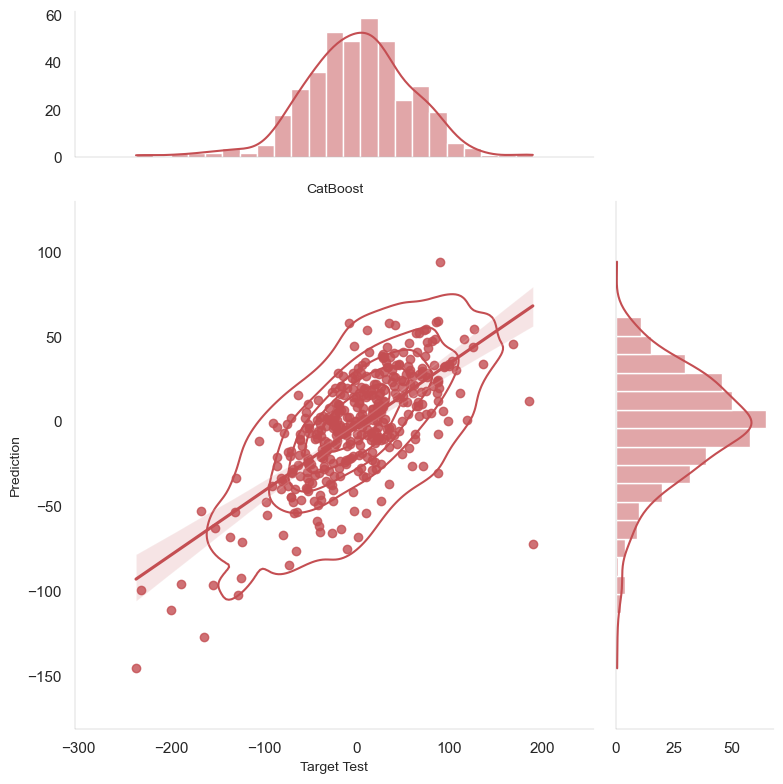

In [111]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1

g = sns.jointplot(x = target_test, y = pred_cb, kind='reg', palette='mako', height=8, ratio=3, marginal_ticks=True, color="r")
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)

plt.title('CatBoost', fontsize=10)
g.set_axis_labels('Target Test', 'Prediction', fontsize=10)

g.fig.tight_layout()
plt.show()

#### <div align="center">Comparison of Models</div>

| Model | RMSE |
|:--------:|:--------:|
|  Linear Regression   |  50.680185491458005   |
|  Random Forest Regressor   |  50.00112232237416   |
|  SGD Regressor   |  95827134443.61758  |
|  CatBoost   |  44.51401030131559   |
|  LGB Regressor   |  43.955727445844154   |
|  XGB Regressor   |  50.82936733453482   |

## Testing

In [115]:
df_differences.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4377 entries, 2018-03-02 15:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   num_orders   4377 non-null   float64
 1   day_of_week  4377 non-null   int32  
 2   month        4377 non-null   int32  
 3   hour         4377 non-null   int32  
 4   day          4377 non-null   int32  
 5   lag_1        4377 non-null   float64
 6   lag_2        4377 non-null   float64
 7   lag_3        4377 non-null   float64
 8   lag_4        4377 non-null   float64
 9   lag_5        4377 non-null   float64
 10  lag_6        4377 non-null   float64
 11  lag_7        4377 non-null   float64
 12  lag_8        4377 non-null   float64
 13  lag_9        4377 non-null   float64
 14  lag_10       4377 non-null   float64
 15  lag_11       4377 non-null   float64
 16  lag_12       4377 non-null   float64
 17  lag_13       4377 non-null   float64
 18  lag_

In [117]:
#Features and target from differences data frame
X = df_differences.drop('num_orders', axis=1)
y = df_differences['num_orders']

#Split the data into a final test set from the differences data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.09, random_state=54321, shuffle=False)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)



(3983, 24)
(394, 24)
(3983,)
(394,)


In [119]:
%%time
#Initialize final LGBM Regression model with best parameters

model_test = lgb.LGBMRegressor(random_state=54321, num_leaves=31, n_jobs=1, n_estimators=300, metric='m', max_depth=20, learning_rate=0.1, class_weight=None, boosting_type='gbdt')

model_test.fit(X_train, y_train)
pred_test = model_test.predict(X_test)

rmse = mean_squared_error(y_test, pred_test) ** 0.5
print(f"The RMSE of the test set is: {rmse}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3882
[LightGBM] [Info] Number of data points in the train set: 3983, number of used features: 24
[LightGBM] [Info] Start training from score 0.011549
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
The RMSE of the test set is: 44.325262058177074
CPU times: total: 516 ms
Wall time: 540 ms
